For Raw Audio

In [19]:
!pip install neptune-client


In [20]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import joblib
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display
import neptune.new as neptune
from neptune.new.types import File

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#____________________________________________________________________________________________________________________________________________________________________________________
n_epochs = int(input('Epochs - '))
lr=float(input('Learning Rate - '))
hidden_dim = int(input('hidden_dim - ')) 
data_set_path = input('Dataset_path - ')#'/content/drive/Shareddrives/G-33-2022/Software/Dataset batch size_512, time window size_4096_no flip.pt'
data_set=torch.load( data_set_path )
train_set = torch.unsqueeze(data_set[0],3)
ground_truth = data_set[1]

#____________________________________________________________________________________________________________________________________________________________________________________
run = neptune.init(
    project="e16103/RNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NTA5YzY1ZS1lOTExLTQ0MTktOTQwZi0xOTA0NTYzNWRkZDgifQ==",
)  # your credentials

#____________________________________________________________________________________________________________________________________________________________________________________
number_of_batches = train_set.size(dim=0)
batch_size = train_set.size(dim=1)
sequence_length = train_set.size(dim=2)
input_size = train_set.size(dim=3)
output_size = 1
#i.e. if your data live in an N-dimensional space and evolve over t-time steps, your input representation must be of shape (num_samples, t, N).
#train set shape = [number_of_batches,batch_size,sequence_length ,input_size]
#____________________________________________________________________________________________________________________________________________________________________________________
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNNModel, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)#, bidirectional = False)   
        # Fully connected layer
        self.fcx = nn.Linear(hidden_dim, output_size)
        
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)
        outX = self.fcx(out)

        return torch.squeeze(outX,2)

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden


class SISNR(nn.Module):
  def __init__(self,time_window_size):
    super(SISNR,self).__init__();
    self.time_window_size=time_window_size
    #self.MSErr = nn.mse_loss()
  def forward(self,predictions, target):
    
    #predictions = Variable(predictions, requires_grad=True)
    #target      = Variable(target, requires_grad=True)
    predictions= torch.reshape(predictions,(-1,1))
    target     = torch.reshape(target,(-1,1))
    starget    = torch.matmul(torch.transpose(predictions,0,1),target)
    starget    = torch.mul(starget,target)
    temp       = torch.matmul(torch.transpose(target,0,1), target)
    starget    = torch.div(starget,temp)
    #enoise     = F.mse_loss(predictions , starget)
    enoise     = torch.sub(predictions , starget)
    starget    = torch.matmul(torch.transpose(starget,0,1), starget)
    enoise     = torch.matmul(torch.transpose(enoise,0,1), enoise)
    loss_value = 10*torch.log10(torch.div(   starget , enoise    ))
    
    return loss_value #snr ---> signal/noise ,to optimize signal should go higher and noise should go down which makees the loss value go up when optimizing.Since pytorchs backward is made to minimize the loss we use 1/loss_value


#____________________________________________________________________________________________________________________________________________________________________________________
model = RNNModel(input_size,input_size,hidden_dim,60).to(device)
#loss_function = nn.MSELoss()
loss_function = SISNR(sequence_length) 
optimizer = optim.Adam(model.parameters(), lr=lr, maximize = True)
#____________________________________________________________________________________________________________________________________________________________________________________

for epoch in range(n_epochs): # 3 full passes over the data
  #  model.train()
    for data in range(number_of_batches):  # `data` is a batch of data
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        out = model.forward(train_set[data].to(device).float())  # pass in the reshaped batch (recall they are 28x28 atm)
        
        loss = loss_function(out, ground_truth[data].to(device).float())
        run["training/batch/loss"].log(loss)
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(epoch,loss)
    

#____________________________________________________________________________________________________________________________________________________________________________________

run["config/dataset/Dataset_path"] = data_set
run["config/dataset/training_data_shape"] = data_set.shape

parameters = {
    "lr": lr,
    "bs": batch_size,
    "input_sz": train_set.shape,
    "output_sz" : out.shape,
    "Number of batches":train_set[0],
    "loss" : SISNR,
    "model_filename":model, "basemodel":RNNModel,
    "device":device,
}
run["config/hyperparameters"] = parameters

run["config/model"] = type(model).__name__
run["config/loss_function"] = type(loss_function).__name__
run["config/optimizer"] = type(optimizer).__name__

fname = 'convTasnet'#parameters["model_filename"]

# Saving model architecture to .txt
with open(f"./{fname}_arch.txt", "w") as f:
    f.write(str(model))

# Saving model weights .pth
torch.save(model.state_dict(), f"./{fname}.pth")

run[f"io_files/artifacts/{fname}_arch"].upload(
    f"./{fname}_arch.txt"
)
run[f"io_files/artifacts/{fname}"].upload(
    f"./{fname}.pth"
)

torch.cuda.empty_cache()
#____________________________________________________________________________________________________________________________________________________________________________________

#____________________________________________________________________________________________________________________________________________________________________________________

#/content/drive/Shareddrives/G-33-2022/Software/Dataset batch size_512, time window size_4096_no flip.pt

https://app.neptune.ai/e16103/RNN/e/RNN-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
0 tensor([[-70.3590]], device='cuda:0', grad_fn=<MulBackward0>)
1 tensor([[-70.4004]], device='cuda:0', grad_fn=<MulBackward0>)
2 tensor([[-70.4727]], device='cuda:0', grad_fn=<MulBackward0>)
3 tensor([[-70.5202]], device='cuda:0', grad_fn=<MulBackward0>)
4 tensor([[-70.5156]], device='cuda:0', grad_fn=<MulBackward0>)
5 tensor([[-70.5304]], device='cuda:0', grad_fn=<MulBackward0>)
6 tensor([[-70.5321]], device='cuda:0', grad_fn=<MulBackward0>)
7 tensor([[-70.5367]], device='cuda:0', grad_fn=<MulBackward0>)
8 tensor([[-70.5393]], device='cuda:0', grad_fn=<MulBackward0>)
9 tensor([[-70.5416]], device='cuda:0', grad_fn=<MulBackward0>)
10 tensor([[-70.5434]], device='cuda:0', grad_fn=<MulBackward0>)
11 tensor([[-70.5451]], device='cuda:0', grad_

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display
model.eval()
m = input('mix path - ')
n = input('vocal path - ')
(test, sr)=librosa.load(m)
(vocal, sr)=librosa.load(n)
n = min(len(vocal),len(test))
#test=test[0:n]+vocal[0:n]

# vocal = librosa.util.normalize(vocal)
# test = librosa.util.normalize(test)



def make_dataset(a,b,shuffle,batch_size,time_window_size,overlapping):        #shuffle is boolean 1 or 0 , batch size > 0. time_window_size = 882 means 20 micrsecond samples are taken in to account,a = input data,b=output expected data,overlapping===> if data overlaps 1,else 0

  data_size = math.floor(len(a)/time_window_size)     #size of data,when more data gets added change this
  training_data = np.zeros((2,data_size,time_window_size), dtype=np.float32)

#making a dataset of input data audio and expected output audio.training_data[0] corresponds to data we input training data[1] corresponds to expected output data
  for i in range(data_size):
    training_data[0][i] = a[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]   #training data (here time windows overlap,for not to overlap =  a[i*time_window_size : i*time_window_size+time_window_size] )
    training_data[1][i] = b[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]  #expected outcome or output data or labels

#shuffle input data to generalise thhe network more
  if (shuffle):
    p = np.random.permutation(len(training_data[1]))
    training_data[0] = training_data[0][p]
    training_data[1] = training_data[1][p]


#dividing in to batch size chunks

  train_set = np.zeros((2,math.floor(data_size/batch_size),batch_size,time_window_size), dtype=np.float32)
  for i in range(math.floor(data_size/batch_size)):
    train_set[0][i] = training_data[0][i*batch_size : i*batch_size+batch_size]
    train_set[1][i] = training_data[1][i*batch_size : i*batch_size+batch_size]

  return train_set


time_window_size = sequence_length
testd = make_dataset(test,vocal,0,batch_size,time_window_size,1)
test_set = torch.from_numpy(testd).to(device)

out = torch.zeros(1,time_window_size).to(device)                #neural network is designed for batch size data chunks.So we got no option but to send data in [batch_size,time_window] size form. Once a time we send [batch_size,time_window] data chunk and concatanate it with an emptyy tensor.
for i in range(len(test_set[0])):
  out = torch.cat(  (out,   model(torch.unsqueeze(test_set[0][i],2) )) , 0 )


def audio_retrieval(out,time_window_size,overlapped):   #out is a tensor.we convert it to a numpy array and concatanate all the batch chunks in to one long vector.then we convert it to a audile audio
  #audio = np.empty([1,len(out)*len(out[0])])
  temp = int(time_window_size/2)
  audio=[]
  if (overlapped):
    separated_voice = out[0].detach().numpy()
    audio=np.concatenate((audio,separated_voice))

    for i in range(len(out)-1):
      separated_voice = out[i+1].detach().numpy()
      audio=np.concatenate( (audio[0:-temp], audio[-int(time_window_size/2):-1]+separated_voice[0:int(time_window_size/2)-1], separated_voice[0:int(time_window_size/2)]))
  else:
    audio=[]
    for i in range(len(out)):
      separated_voice = out[i].detach().numpy()
      audio=np.concatenate((audio,separated_voice))

  audio=librosa.util.normalize(audio)
  n = min(len(vocal),len(audio))
  mse = ((vocal[0:n] - audio[0:n])**2).mean(axis=0)
  print("MSE = ",mse)
  return audio

#audio=audio_retrieval(out)
#audio=(audio-np.mean(audio))
#print((audio).shape)
#sf.write('stereo_file.flac',audio, 44100)

#plot data
#plt.figure(1)
#plt.title("original Signal vs predicted signal")
#plt.plot(audio)
#plt.plot(sig_voice)
#plt.show()

aud=audio_retrieval(out[1 :].to('cpu'),time_window_size,0)



#sf.write('separated_song1.flac',aud, sr)


mix path - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/mix.wav
vocal path - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/Lead_voxes.wav
MSE =  1.0016411326480674


lakuna mixx - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/mix.wav

lakuna vocal - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/Lead_voxes.wav


living the colour mix- /content/drive/Shareddrives/G-33-2022/Audios/To do/Living Colour/Cult of Personality (Living Colour)/mix.wav

living the colour vocal - /content/drive/Shareddrives/G-33-2022/Audios/To do/Living Colour/Cult of Personality (Living Colour)/song.ogg

In [22]:
sf.write('separated_song.wav',aud, sr)
sf.write('mix_song.wav',test, sr)
songname = 'Lacuna_Coil'

In [23]:
run[f"audio/{songname}/separated song"].upload("/content/separated_song.wav")
run[f"audio/{songname}/mixture file"].upload("/content/mix_song.wav")

In [24]:
n = min(len(vocal),len(aud))
mse = ((vocal[0:n] - aud[0:n])**2).mean(axis=0)
print("MSE = ",mse)
loss_function = SISNR(n)
loss = loss_function(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
print("SISNR = ", loss)

run[f"test files/lossMSE-{songname}"].log(mse)

run[f"test files/lossSISNR-{songname}"].log(loss)

MSE =  1.0016411326480674
SISNR =  tensor([[-59.7109]], dtype=torch.float64)


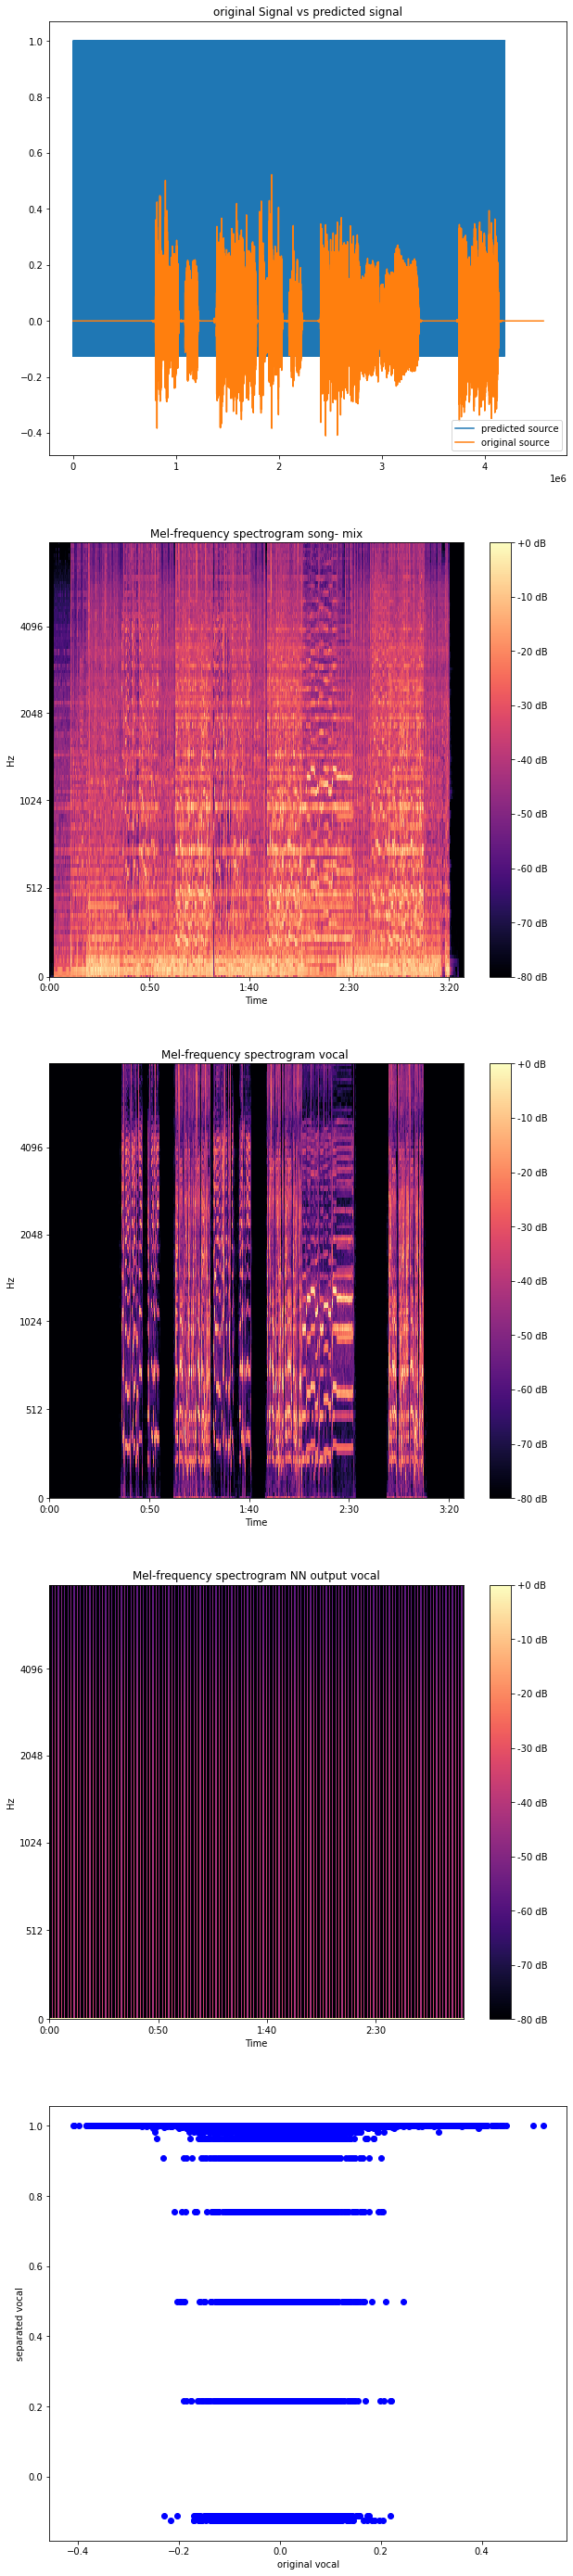

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/e16103/RNN/e/RNN-8


In [25]:

import matplotlib.pyplot as plt
import librosa.display


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(50)

ax1 = fig.add_subplot(5,1,1)
plt.title("original Signal vs predicted signal")
ax1.plot(aud)
ax1.plot(vocal)
plt.legend(["predicted source", "original source"], loc ="lower right")


S = librosa.feature.melspectrogram(y=test, sr=sr, n_mels=128,
                                    fmax=8000)
ax2 = fig.add_subplot(5,1,2)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax2)
fig.colorbar(img, ax=ax2, format='%+2.0f dB')
ax2.set(title='Mel-frequency spectrogram song- mix')



S = librosa.feature.melspectrogram(y=vocal, sr=sr, n_mels=128,
                                    fmax=8000)

ax3 = fig.add_subplot(5,1,3)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax3)
fig.colorbar(img, ax=ax3, format='%+2.0f dB')
ax3.set(title='Mel-frequency spectrogram vocal ')



S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128,
                                    fmax=8000)
ax4 = fig.add_subplot(5,1,4)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax4)
fig.colorbar(img, ax=ax4, format='%+2.0f dB')
ax4.set(title='Mel-frequency spectrogram NN output vocal')

ax5 = fig.add_subplot(5,1,5)
n = min(len(vocal),len(aud))
ax5.scatter(vocal[0:n],aud[0:n], c ="blue")
plt.xlabel("original vocal")
plt.ylabel("separated vocal")

plt.show()

run["images/predictions"].log( File.as_image(fig))

run.stop()